In [1]:
import pandas as pd
import random
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [3]:
from nltk.stem import WordNetLemmatizer

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the data by removing punctuation, numbers, stopwords, and short words.
    """
    # lowercase
    data["text"] = data["text"].apply(lambda x: x.lower())
    # remove punctuation
    data["text"] = data["text"].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    # remove numbers
    data["text"] = data["text"].apply(lambda x: re.sub(r"\d+", "", x))
    # remove stopwords
    stop = stopwords.words("english")
    data["text"] = data["text"].apply(
        lambda x: " ".join(x for x in x.split() if x not in stop)
    )
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    data["text"] = data["text"].apply(
        lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split())
    )
    # remove short words
    data["text"] = data["text"].apply(
        lambda x: " ".join(x for x in x.split() if len(x) > 3)
    )
    return data


In [4]:
def create_label_words(data: pd.DataFrame, label: str) -> pd.Series:
    """
    Create a list of words from a given label
    """
    label_words = []
    for text in data[data["label"] == label]["text"]:
        for word in text.split():
            label_words.append(word)
    label_words = pd.Series(label_words)
    return label_words

In [5]:
def create_vocab(data: list) -> list:
    """
    Create a vocabulary from a given list of words
    """
    vocab = set()
    for text in data:
        for word in text.split():
            vocab.add(word)
    vocab = list(vocab)
    return vocab

In [6]:
def prepare_dataset(dataset_path: str) -> tuple:
    """
    This function takes the path of the dataset and returns the vocabulary and the word counts for each label.
    """
    DATA_PATH = dataset_path
    data = pd.read_csv(DATA_PATH)
    data = data.rename(columns={"text": "text", "category": "label"})
    data = preprocess_data(data)
    
    vocab =  create_vocab(data["text"])
    labels = data["label"].unique()
    
    first_label = labels[0]
    second_label = labels[1]

    first_label_words = create_label_words(data, first_label)
    second_label_words = create_label_words(data, second_label)

    first_label_words = first_label_words.value_counts()
    second_label_words = second_label_words.value_counts()

    return vocab, first_label_words, second_label_words

In [7]:
def create_individual(word_count: int, vocab: list) -> list:
    """
    Creates an individual with a given word count and vocabulary.
    """
    individual = [[], []]
    for i in range(word_count // 2): 
        individual[0].append(random.choice(vocab))
        individual[1].append(random.choice(vocab))
    return individual

In [8]:
def create_population(population_size: int, word_count: int, vocab: list) -> list:
    """
    Creates a population with a given size, word count, and vocabulary.
    """
    population = []
    for i in range(population_size):
        individual = create_individual(word_count, vocab)
        if individual not in population:
            population.append(individual)
    return population

In [9]:
def find_fitness(
    individual: list, first_label_words: pd.Series, second_label_words: pd.Series
) -> int:
    """
    Finds the fitness of an individual.
    """
    fitness = 0
    for word in individual[0]:
        if word in first_label_words:
            fitness += first_label_words[word]
        if word in second_label_words:
            fitness -= second_label_words[word]
    for word in individual[1]:
        if word in second_label_words:
            fitness += second_label_words[word]
        if word in first_label_words:
            fitness -= first_label_words[word]
    return fitness

In [10]:
def find_population_fitness(
    population: list, first_label_words: pd.Series, second_label_words: pd.Series
) -> list:
    """
    Finds the fitness of each individual in a population.
    """
    population_fitness = []
    for individual in population:
        population_fitness.append(
            find_fitness(individual, first_label_words, second_label_words)
        )
    return population_fitness

In [11]:
def find_best(population: list, population_fitness: list) -> list:
    """
    Finds the best individual in a population.
    """
    best_index = population_fitness.index(max(population_fitness))
    return population[best_index]

In [12]:
def find_elites(population: list, population_fitness: list, elite_size: int) -> list:
    """
    Finds the elite individuals in a population.
    """
    elites = []
    for i in range(elite_size):
        best_index = population_fitness.index(max(population_fitness))
        elites.append(population[best_index])
        population_fitness[best_index]
    return elites

In [13]:
def crossover(parent1: list, parent2: list) -> list:
    """
    Creates a child from two parents.
    """
    child = [[], []]
    for i in range(len(parent1[0])):
        if random.random() > 0.5:
            child[0].append(parent1[0][i])
            child[1].append(parent2[1][i])
        else:
            child[0].append(parent2[0][i])
            child[1].append(parent1[1][i])
    return child

In [14]:
def mutate(individual: list, mutation_rate: float, vocab: list) -> list:
    """
    Mutates an individual.
    """
    for i in range(len(individual[0])):
        if random.random() < mutation_rate:
            individual[0][i] = random.choice(vocab)
        if random.random() < mutation_rate:
            individual[1][i] = random.choice(vocab)
    return individual

In [15]:
def check_if_unique(individual: list) -> bool:
    """
    Checks if an individual is unique. Purpose is to avoid duplicates in a population.
    """
    # Check if individual[0] and individual[1] is unique
    if len(set(individual[0])) != len(individual[0]):
        return False
    if len(set(individual[1])) != len(individual[1]):
        return False
    return True


def evolve(
    population: list,
    population_fitness: list,
    elite_size: int,
    mutation_rate: float,
    vocab: list,
) -> list:
    """
    Evolves a population.
    """
    elites = find_elites(population, population_fitness, elite_size)
    next_generation = elites
    while len(next_generation) < len(population):
        parent1 = random.choice(next_generation)
        parent2 = random.choice(next_generation)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate, vocab)
        if child not in next_generation and check_if_unique(child):
            next_generation.append(child)
    return next_generation

In [16]:
def genetic_algorithm(
    population_size: int,
    elite_size: int,
    mutation_rate: float,
    generation_count: int,
    word_count: int,
    vocab: list,
    first_label_words: pd.Series,
    second_label_words: pd.Series,
) -> tuple:
    """
    Runs the genetic algorithm.
    """
    population = create_population(population_size, word_count, vocab)
    plot_data = {}
    for i in range(generation_count):
        population_fitness = find_population_fitness(
            population, first_label_words, second_label_words
        )
        population = evolve(
            population, population_fitness, elite_size, mutation_rate, vocab
        )
        plot_data[i] = {
            "max": max(population_fitness),
            "avg": sum(population_fitness) / len(population_fitness),
        }
    population_fitness = find_population_fitness(
        population, first_label_words, second_label_words
    )
    best = find_best(population, population_fitness)
    return best, population_fitness, plot_data

In [17]:
def plot_generations_fitness_graph(plot_data: dict, title: str, description: str = None):
    """
    Plots the fitness of max and avg fitness of each generation.
    """
    plt.figure(figsize=(5, 5))
    plt.plot(
        list(plot_data.keys()),
        [plot_data[key]["max"] for key in plot_data.keys()],
        label="Max",
    )
    plt.plot(
        list(plot_data.keys()),
        [plot_data[key]["avg"] for key in plot_data.keys()],
        label="Avg",
    )
    plt.legend()
    plt.title(title)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    if description:
        plt.text(25, 50, description)
    return plt

In [18]:
data_path = "/kaggle/input/binary-text-classification/sports_sci-tech.csv"
PARAMETER_LIST = [
    # word_count changes
    [
        {
            "population_size": 500,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 500,
            "word_count": 110,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 500,
            "word_count": 120,
            "mutation_rate": 0.01,
        },
    ],
    # population_size changes
    [
        {
            "population_size": 500,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 600,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 700,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
    ],
    # mutation_rate changes
    [
        {
            "population_size": 500,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 500,
            "word_count": 100,
            "mutation_rate": 0.05,
        },
        {
            "population_size": 500,
            "word_count": 100,
            "mutation_rate": 0.10,
        },
    ],
]

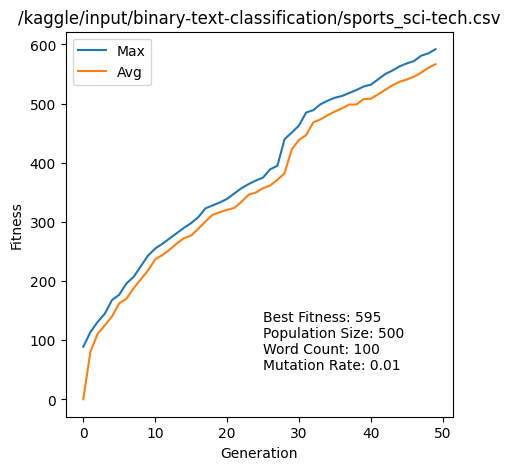

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 500, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['fiftyfive', 'took', 'twin', 'tight', 'angeles', 'basketball', 'olympic', 'delivery', 'saturday', 'give', 'semifinal', 'dorman', 'inning', 'drive', 'toddle', 'team', 'begin', 'phelps', 'made', 'budapest', 'olerud', 'eight', 'tomko', 'single', 'night', 'philadelphia', 'championship', 'quest', 'kostas', 'united', 'grand', 'diamondback', 'left', 'sunday', 'strait', 'outlasts', 'medal', 'player', 'beat', 'gold', 'career', 'triggering', 'clash', 'athens', 'defies', 'california', 'niceandeasy', 'israeli', 'olympics', 'diego'], ['hubble', 'asteroid', 'build', 'highly', 'blog', 'nasa', 'would', 'astronaut', 'study', 'denver', 'promised', 'long', 'system', 'saudi', 'validity', 'tuesday', 'unhandled', 'number', 'texas', 'debian', 'spacecom', 'moon', 'rightwing', 'space', 'huge', 'federal', 'visual', 'dock', 'working', 'rose', '

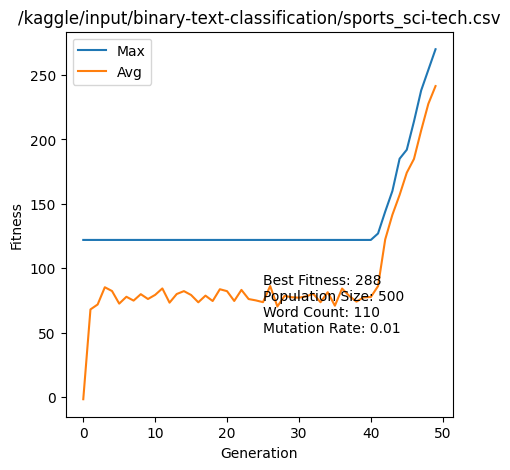

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 500, 'word_count': 110, 'mutation_rate': 0.01}
Best individual: [['deficit', 'cool', 'gift', 'financed', 'growing', 'facing', 'twin', 'loss', 'baltimore', 'unbeaten', 'announcement', 'dock', 'kerry', 'rica', 'mundane', 'eagle', 'wave', 'parker', 'copper', 'battle', 'firstplace', 'earned', 'world', 'secondplace', 'sink', 'player', 'asmuch', 'treat', 'inning', 'singh', 'play', 'america', 'phone', 'predish', 'greeted', 'sprawl', 'team', 'dinosaur', 'code', 'wilder', 'ministry', 'universe', 'even', 'cruised', 'enjoying', 'oceanport', 'gold', 'appleby', 'round', 'defied', 'pimlico', 'birthday', 'rivalry', 'sunday', 'match'], ['debut', 'speed', 'usemyapplicationservermax_connections', 'born', 'osama', 'human', 'shuttle', 'spacecom', 'annual', 'nice', 'suffered', 'forecaster', 'internetservice', 'detrimentally', 'loggergetlogger', 'able', 'browser', 'solvedalthough', 'minority', 'people', 

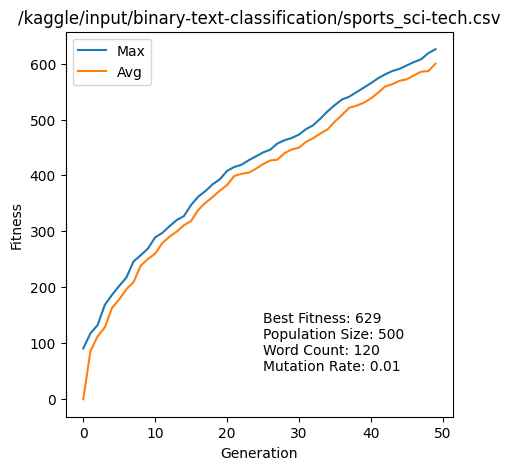

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 500, 'word_count': 120, 'mutation_rate': 0.01}
Best individual: [['four', 'dimarco', 'sunday', 'team', 'inning', 'ottawa', 'championship', 'final', 'round', 'pace', 'hall', 'mike', 'game', 'tour', 'relay', 'missed', 'amateur', 'sept', 'kenteris', 'athens', 'impress', 'whats', 'mashiska', 'brazil', 'legislative', 'roenick', 'singh', 'williamsons', 'budapest', 'clear', 'normal', 'page', 'beasley', 'effort', 'olympic', 'record', 'seal', 'academic', 'kasay', 'allmet', 'medium', 'night', 'medal', 'gardening', 'association', 'first', 'quest', 'gambler', 'single', 'player', 'leonard', 'left', 'phelps', 'victory', 'free', 'beat', 'indian', 'field', 'dolphinsafe', 'basketball'], ['heating', 'called', 'around', 'spacecom', 'order', 'delight', 'various', 'generates', 'nasa', 'telescope', 'life', 'highspeed', 'clone', 'little', 'many', 'manned', 'dolphin', 'agency', 'quality', 'guide', 'people'

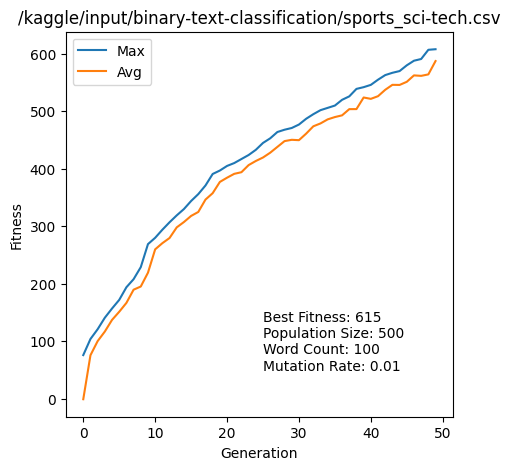

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 500, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['yankee', 'tech', 'singh', 'williamsons', 'olympic', 'begin', 'game', 'puerto', 'robert', 'walsh', 'oriole', 'challenge', 'displayed', 'sally', 'beat', 'inning', 'wrangle', 'sweep', 'night', 'indian', 'earned', 'homer', 'wrap', 'along', 'gold', 'final', 'made', 'phelps', 'qualifying', 'double', 'sunday', 'michael', 'knock', 'leonard', 'smile', 'track', 'defied', 'sport', 'title', 'first', 'tworun', 'iran', 'medal', 'association', 'rico', 'esteban', 'important', 'clubbed', 'athens', 'team'], ['human', 'vibrant', 'group', 'wednesday', 'recent', 'explorer', 'born', 'technology', 'never', 'mozilla', 'scientist', 'aerial', 'rocket', 'working', 'time', 'death', 'dont', 'risk', 'asteroid', 'earth', 'better', 'chorus', 'turn', 'afraid', 'mission', 'monthold', 'standard', 'plan', 'alike', 'cloned', 'rule', 'spacecom', 'bird', 

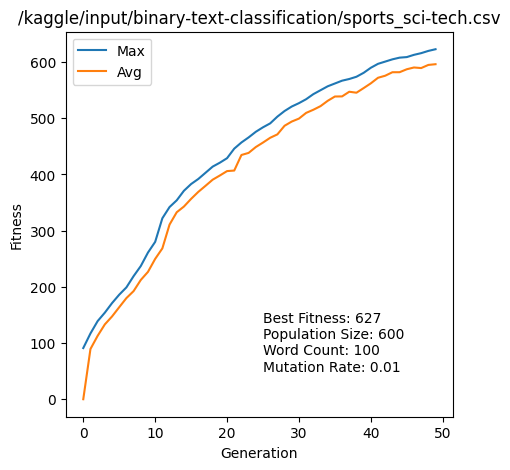

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 600, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['game', 'olympic', 'vijay', 'prokom', 'single', 'final', 'quest', 'sweep', 'coach', 'wood', 'appeared', 'field', 'saturday', 'setback', 'athens', 'race', 'awkward', 'english', 'sunday', 'inning', 'header', 'athlete', 'quotsister', 'beat', 'olympics', 'atlanta', 'hungarian', 'gold', 'nationwide', 'eight', 'title', 'player', 'team', 'smudged', 'night', 'constructor', 'harsh', 'medal', 'dimarco', 'first', 'basketball', 'wily', 'phelps', 'record', 'minnesota', 'phelpss', 'season', 'victory', 'wrap', 'freestyle'], ['feed', 'linuxworld', 'enter', 'plan', 'rocket', 'said', 'wildfire', 'previously', 'dolphin', 'shower', 'earth', 'kinda', 'temporary', 'killed', 'logger', 'texas', 'misery', 'space', 'asset', 'launched', 'predict', 'implementation', 'evidence', 'britain', 'administration', 'like', 'simulation', 'nothing', 'likel

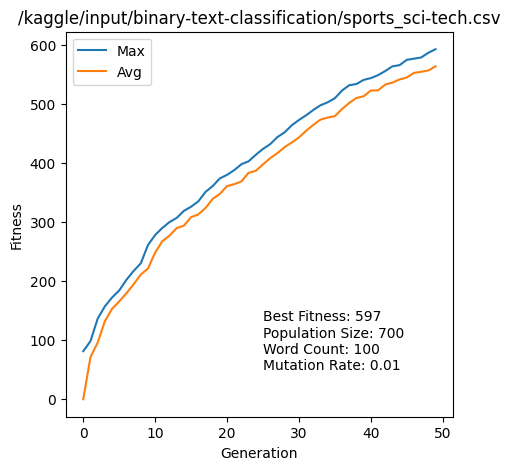

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 700, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['unbeaten', 'inning', 'brewer', 'team', 'quotwalter', 'hartman', 'formula', 'champion', 'committee', 'quotsister', 'opening', 'produced', 'championship', 'race', 'indian', 'tiger', 'sand', 'triumph', 'basketball', 'minnesota', 'dimarco', 'seattle', 'olympics', 'athens', 'loss', 'complete', 'walter', 'sunday', 'michael', 'gold', 'qualifying', 'first', 'reuters', 'game', 'olympic', 'accused', 'downed', 'running', 'ninegame', 'come', 'folk', 'four', 'medal', 'woman', 'title', 'league', 'franco', 'lead', 'steve', 'sing'], ['said', 'sale', 'would', 'airsea', 'wireless', 'force', 'arabia', 'thursday', 'country', 'people', 'handy', 'question', 'many', 'environmental', 'highly', 'nothing', 'work', 'growth', 'hooked', 'spacecom', 'tmobile', 'scientist', 'engineer', 'massively', 'developer', 'saudi', 'feed', 'planned', 'capital

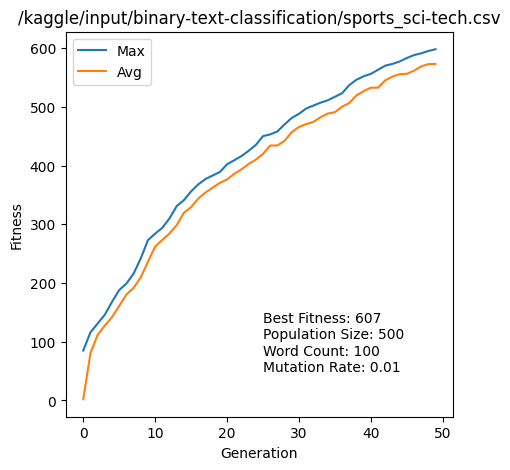

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 500, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['flesch', 'philadelphia', 'channel', 'team', 'vijay', 'school', 'victory', 'championship', 'leonard', 'landscape', 'david', 'season', 'snare', 'jeremy', 'stahl', 'singh', 'saturday', 'york', 'stayed', 'player', 'ironic', 'united', 'ended', 'dimarco', 'slide', 'fraud', 'snap', 'sunday', 'tech', 'first', 'eight', 'judo', 'phelps', 'medal', 'perched', 'basketball', 'beat', 'buried', 'landline', 'mccartys', 'athens', 'inning', 'game', 'counted', 'olympic', 'pitcher', 'puerto', 'tworun', 'olerud', 'cleveland'], ['using', 'silicon', 'rethinking', 'company', 'increased', 'student', 'believe', 'computer', 'technology', 'outward', 'wont', 'august', 'rapist', 'never', 'find', 'service', 'time', 'asteroid', 'wanted', 'tuesday', 'scientist', 'aerial', 'earth', 'suspicion', 'ayad', 'statement', 'space', 'trash', 'posted', 'could',

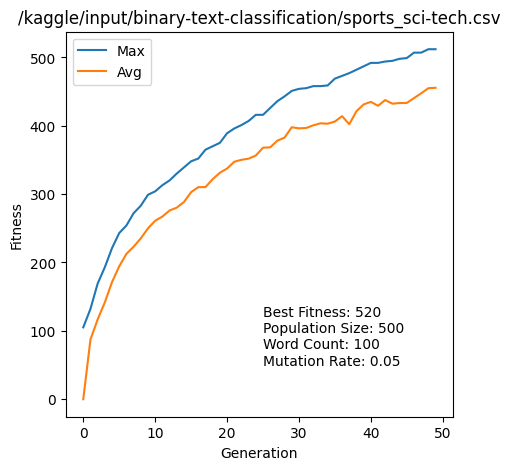

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 500, 'word_count': 100, 'mutation_rate': 0.05}
Best individual: [['second', 'athens', 'beat', 'goahead', 'giving', 'star', 'tournament', 'championship', 'homer', 'leonard', 'gold', 'victory', 'wisconsin', 'night', 'title', 'sunsplashed', 'padre', 'meter', 'injury', 'kohler', 'sunday', 'defeat', 'castillo', 'acasuso', 'vertical', 'shot', 'reveled', 'coach', 'crowd', 'indian', 'shoulder', 'olympic', 'amateur', 'state', 'budapest', 'israel', 'season', 'inquirer', 'defied', 'lineman', 'koskie', 'phelps', 'schumacher', 'twogame', 'prokom', 'team', 'paid', 'handicap', 'medal', 'major'], ['joining', 'work', 'grows', 'speculation', 'launch', 'seems', 'rodent', 'abusing', 'install', 'threeunderpar', 'stake', 'carry', 'death', 'safely', 'space', 'waste', 'vice', 'texas', 'scientific', 'said', 'suspect', 'cassini', 'well', 'canal', 'probe', 'many', 'wednesday', 'thank', 'human', 'likely', 'spa

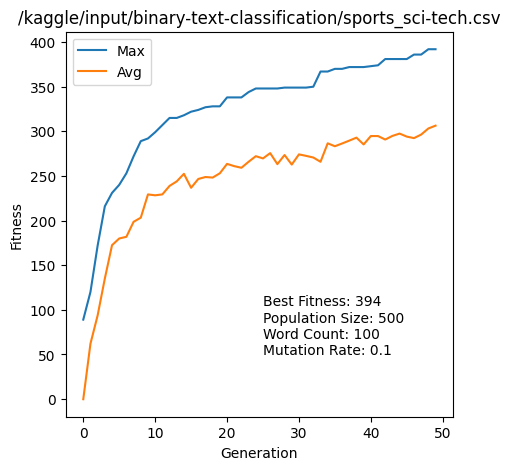

--- /kaggle/input/binary-text-classification/sports_sci-tech.csv Results ---
Params: {'population_size': 500, 'word_count': 100, 'mutation_rate': 0.1}
Best individual: [['track', 'gold', 'meter', 'late', 'olympic', 'kerney', 'saturday', 'sofronie', 'team', 'revolution', 'began', 'birthday', 'highly', 'chris', 'curtis', 'fiftyfive', 'diedyoung', 'normal', 'schumacher', 'player', 'lead', 'trial', 'hall', 'sunday', 'club', 'israeli', 'championship', 'bracing', 'sierra', 'poll', 'twin', 'since', 'athens', 'last', 'nobel', 'volleyball', 'bruce', 'title', 'play', 'quest', 'jeremy', 'googlefor', 'jeopardy', 'final', 'squid', 'state', 'back', 'angeles', 'attack', 'leonard'], ['authority', 'taiwan', 'floating', 'launch', 'nobel', 'dayand', 'together', 'teen', 'spacecom', 'install', 'surveyed', 'suffered', 'previously', 'parker', 'university', 'beast', 'surprise', 'invasive', 'clannish', 'stake', 'shower', 'large', 'locust', 'confidential', 'peak', 'dolphinsafe', 'weed', 'said', 'lunch', 'wednes

In [19]:
best_individuals_list = []
for parameters in PARAMETER_LIST:
    for parameter in parameters:
        best_individuals_for_params = [] 
        vocab, first_label_words, second_label_words = prepare_dataset(
            data_path
        )
        best, population_fitness, plot_data = genetic_algorithm(
            population_size=parameter["population_size"],
            elite_size=40,
            mutation_rate=parameter["mutation_rate"],
            generation_count=50,
            word_count=parameter["word_count"],
            vocab=vocab,
            first_label_words=first_label_words,
            second_label_words=second_label_words,
        )
        best_individuals_for_params.append(best)
        plot_image = plot_generations_fitness_graph(
            plot_data,
            data_path,
            f"Best Fitness: {max(population_fitness)}\nPopulation Size: {parameter['population_size']}\nWord Count: {parameter['word_count']}\nMutation Rate: {parameter['mutation_rate']}",
        )
        plot_image.show()
        print(f"--- {data_path} Results ---")
        print("Params:", parameter)
        print("Best individual:", best)
        print("Best fitness:", max(population_fitness))
        best_individuals_list.append(best_individuals_for_params)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

evaluation_results = []
i=0
data = pd.read_csv(data_path)
data = data.rename(columns={"text": "text", "category": "label"})
    
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

best_individual = best_individuals_list[i][0][0] + best_individuals_list[i][0][1]
best_individual = list(set(best_individual))

vectorizer = TfidfVectorizer(vocabulary=best_individual)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
    
    # Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
    
predictions = naive_bayes_model.predict(X_test)
report = classification_report(y_test, predictions, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
    
evaluation_results.append({
        'Dataset': data_path[i],
        'Model': 'Multinomial Naive Bayes',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

    # Gaussian Naive Bayes
gaussian_nb_model = GaussianNB()
gaussian_nb_model.fit(X_train.toarray(), y_train)
    
predictions = gaussian_nb_model.predict(X_test.toarray())
report = classification_report(y_test, predictions, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
    
evaluation_results.append({
        'Dataset': data_path[i],
        'Model': 'Gaussian Naive Bayes',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

    # SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
    
predictions = svm_model.predict(X_test)
report = classification_report(y_test, predictions, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
    
evaluation_results.append({
        'Dataset': data_path[i],
        'Model': 'SVM',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

evaluation_results_df = pd.DataFrame(evaluation_results)
evaluation_results_df


,Dataset,Model,Accuracy,Precision,Recall,F1-Score
0,/,Multinomial Naive Bayes,0.900,0.904511,0.900,0.900000
1,/,Gaussian Naive Bayes,0.750,0.758000,0.750,0.746164
2,/,SVM,0.875,0.875631,0.875,0.874764
